In [48]:
%matplotlib notebook

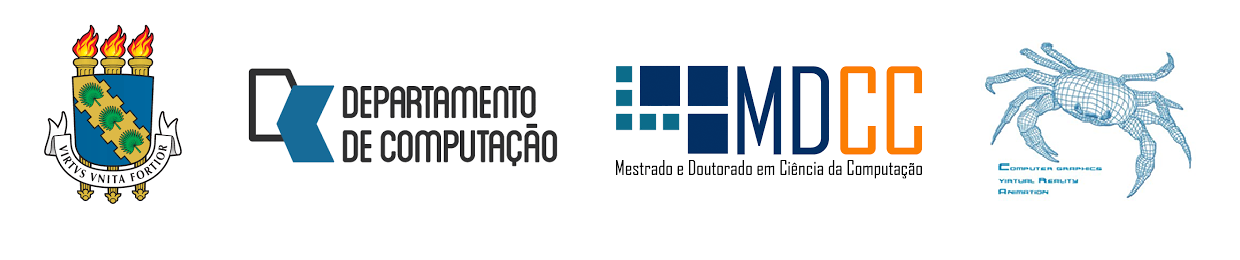

<div style="text-align: center"> 
    <h1>Curso de Geometria Computacional</h1>
    <h3>CKP8088</h3>
    <h1>Programa de Mestrado e Doutorado em Ciência da Computação - MDCC</h1>
    <h3>Universidade Federal do Ceará</h3>
    <h1>Algoritmo do Embrulho 3D & Avanço 3D</h1>
    <h2>Fecho Convexo e Tetraedralização</h2>
    <h2>Gustavo Mota</h2>
    <h3>2022.1</h3>
</div>

In [1]:
import os
import sys
import numpy as np
from math import sqrt
from math import pow

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

In [3]:
#import scipy.spatial as scp
from scipy.spatial import Delaunay

## Funções auxiliares

In [2]:
def splitFace(face):
    aux_vtx = []
    aux_vtx.append(face[0][0])
    for aresta in face:
        for vtx in aresta:
            if vtx not in aux_vtx:
                aux_vtx.append(vtx)
    return aux_vtx

def pontoOposto(aresta, vtx_face):
    for vtx in vtx_face:
        if vtx not in aresta:
            return vtx
        
def calc_normal(aresta, ponto):
    # produto vetorial 
    A = np.array(aresta[0])
    B = np.array(ponto)
    AB = np.subtract(A, B)
    C = np.array(aresta[0])
    D = np.array(aresta[1])
    CD = np.subtract(C, D)
    try:
        return [
            AB[1]*CD[2] - AB[2]*CD[1],
            AB[2]*CD[0] - AB[0]*CD[2],
            AB[0]*CD[1] - AB[1]*CD[0]
        ]
    except:
        print('error: ', AB, CD)

def produtoEsc(normal_p, normal_):
    return sum([x*y for x, y in zip(normal_p, normal_)])

def calc_nor(aresta):
    #print( aresta)
    return sqrt(sum([pow(x, 2) for x in aresta]))

def faces_spliter(faces):
    splits = []
    for face in faces:
        splited = splitFace(face)
        x = np.array([x[0] for x in splited])
        y = np.array([y[1] for y in splited])
        z = np.array([z[2] for z in splited])
        splits.append([x,y,z])
    return splits

## Importando objeto

In [3]:
os.getcwd()
os.chdir("obj")
files = [i for i in os.listdir()]
files

['.ipynb_checkpoints',
 'airplane-reduced.mtl',
 'airplane-reduced.obj',
 'airplane-ultra-simplified.mtl',
 'airplane-ultra-simplified.obj',
 'airplane.mtl',
 'airplane.obj',
 'asa_dir_finalmente.obj',
 'asa_dir_finalmente2.obj',
 'asa_dir_finalmente3.obj',
 'asa_dir_finalmente4.obj',
 'cubo_default.mtl',
 'cubo_default.obj',
 'cubo_refeito.obj',
 'cubo_refeito10.obj',
 'cubo_refeito2.obj',
 'cubo_refeito3.obj',
 'cubo_refeito4.obj',
 'cubo_refeito5.obj',
 'cubo_refeito6.obj',
 'cubo_refeito7.obj',
 'cubo_refeito8.obj',
 'cubo_refeito9.obj',
 'face_1_finalmente.obj',
 'face_1_finalmente2.obj',
 'face_1_finalmente3.obj',
 'outputs',
 'teste.obj',
 'teste2.obj',
 'testeasa.stl',
 'teste_4.obj',
 'teste_5.obj',
 'teste_face.obj',
 'testing_newSTL.stl']

In [4]:
os.getcwd()
#os.chdir("obj")
cubo = [i for i in os.listdir()][12]
cubo

'cubo_default.obj'

In [5]:
def objDataToVertices(nameFile):
    with open(nameFile, 'r') as f:
        odata = f.readlines()
    # odata is the string read from an obj file
    vertices = []
    vectorVertices = []
    # lines = odata.splitlines()

    for line in odata:
        
        slist = line.split()
        if slist:
            
            if slist[0] == 'o':
                print(slist)
                if len(vertices)==0:
                    continue
                
                vectorVertices.append(vertices)
                # print(slist[1:], len(vectorVertices))
                vertices = []
            if slist[0] == 'v':
                
                vertex = np.array(slist[1:], dtype=float)
                vertex = vertex.tolist()
                # vertex = float(slist[1:])
                vertices.append(vertex)
            else: pass
    
    vectorVertices.append(vertices)
    print(len(vectorVertices))
    return vectorVertices

In [6]:
airplane_ultra = objDataToVertices(files[4])

['o', 'wing_2_Mat_0']
['o', 'rear_fin_Mat_0']
['o', 'rear_fin_2_Mat_0']
['o', 'tail_Mat_0']
['o', 'wing_1_Mat_0']
['o', 'fusilage_new_Mat_0']
6


In [6]:
cubo = objDataToVertices(cubo)
cubo

['o', 'Cube']
1


[[[1.0, 1.0, -1.0],
  [1.0, -1.0, -1.0],
  [1.0, 1.0, 1.0],
  [1.0, -1.0, 1.0],
  [-1.0, 1.0, -1.0],
  [-1.0, -1.0, -1.0],
  [-1.0, 1.0, 1.0],
  [-1.0, -1.0, 1.0]]]

In [7]:
airplane_ultra_wing01 = airplane_ultra[0]
airplane_rear_fin_01 = airplane_ultra[1]
airplane_rear_fin_02 = airplane_ultra[2]
airplane_tail_mat_01 = airplane_ultra[3]
airplane_ultra_wing02 = airplane_ultra[4]
airplane_fusilage_01 = airplane_ultra[5]

# Pré-processamento do objeto

#### Eliminando repetição de pontos:

In [8]:
airplane_ultra_wing01 = list(set([str(vtx) for vtx in airplane_ultra_wing01]))

airplane_sr_rear_fin_01 = list(set([str(vtx) for vtx in airplane_rear_fin_01]))
airplane_sr_rear_fin_02 = list(set([str(vtx) for vtx in airplane_rear_fin_02]))
airplane_sr_tail_mat_01 = list(set([str(vtx) for vtx in airplane_tail_mat_01]))
airplane_ultra_sr_wing02 = list(set([str(vtx) for vtx in airplane_ultra_wing02]))
airplane_sr_fusilage_01 = list(set([str(vtx) for vtx in airplane_fusilage_01]))

#### Restauração do objeto:

In [9]:
airplane_sr2_ultra_wing01 = [list(vtx) for vtx in airplane_ultra_wing01]

airplane_sr2_rear_fin_01 = [list(vtx) for vtx in airplane_sr_rear_fin_01]
airplane_sr2_rear_fin_02 = [list(vtx) for vtx in airplane_sr_rear_fin_02]
airplane_sr2_tail_mat_01 = [list(vtx) for vtx in airplane_sr_tail_mat_01]
airplane_ultra_sr2_wing02 = [list(vtx) for vtx in airplane_ultra_sr_wing02]
airplane_sr2_fusilage_01 = [list(vtx) for vtx in airplane_sr_fusilage_01]

In [10]:
pieces_restore = [
    airplane_sr2_ultra_wing01,
    airplane_sr2_rear_fin_01,
    airplane_sr2_rear_fin_02,
    airplane_sr2_tail_mat_01,
    airplane_ultra_sr2_wing02,
    airplane_sr2_fusilage_01
]

In [11]:
i = 0
str_to_float = ''
for char in airplane_ultra_wing01[i][1:-1]:
    str_to_float += char
spl = str_to_float.split(',')
vtx = [float(str_vtx) for str_vtx in spl]

In [12]:
reconstructed_obj = []
for idx_piece, piece in enumerate(pieces_restore):
    print('piece number: ', idx_piece)
    str_to_float = ''
    intermediate_piece = []
    for i in range(len(piece)):
        print(i)
        str_to_float = ''
        vtx = []
        for char in piece[i][1:-1]:
            str_to_float += char
        spl = str_to_float.split(',')
        vtx = [float(str_vtx) for str_vtx in spl]
        print(spl)
        print(vtx)
        intermediate_piece.append(vtx.copy())
    reconstructed_obj.append(intermediate_piece.copy())


piece number:  0
0
['-0.471029', ' 1.646606', ' 2.670001']
[-0.471029, 1.646606, 2.670001]
1
['-0.357922', ' 2.106695', ' 3.854114']
[-0.357922, 2.106695, 3.854114]
2
['-0.202863', ' 1.955364', ' 3.68644']
[-0.202863, 1.955364, 3.68644]
3
['-1.06489', ' 2.582114', ' 4.439732']
[-1.06489, 2.582114, 4.439732]
4
['0.024615', ' 1.579111', ' 2.432529']
[0.024615, 1.579111, 2.432529]
5
['-0.437495', ' 1.939061', ' 2.358001']
[-0.437495, 1.939061, 2.358001]
6
['-0.984815', ' 2.143964', ' 3.953227']
[-0.984815, 2.143964, 3.953227]
7
['-0.98057', ' 1.979263', ' 3.153889']
[-0.98057, 1.979263, 3.153889]
8
['-1.013609', ' 1.996646', ' 3.410638']
[-1.013609, 1.996646, 3.410638]
9
['-0.947793', ' 2.512706', ' 4.488287']
[-0.947793, 2.512706, 4.488287]
10
['-0.354864', ' 1.963371', ' 1.279073']
[-0.354864, 1.963371, 1.279073]
11
['-0.717027', ' 1.962422', ' 4.166115']
[-0.717027, 1.962422, 4.166115]
12
['0.282954', ' 1.603692', ' 2.169513']
[0.282954, 1.603692, 2.169513]
13
['0.472677', ' 1.582795',

122
['-0.778482', ' 2.312565', ' 4.439547']
[-0.778482, 2.312565, 4.439547]
123
['-0.827426', ' 1.828339', ' 3.177128']
[-0.827426, 1.828339, 3.177128]
124
['0.024191', ' 2.006317', ' 1.29409']
[0.024191, 2.006317, 1.29409]
125
['-0.47525', ' 1.967046', ' 2.626347']
[-0.47525, 1.967046, 2.626347]
126
['-0.120767', ' 1.750905', ' 3.219887']
[-0.120767, 1.750905, 3.219887]
127
['-0.692848', ' 2.288567', ' 4.330555']
[-0.692848, 2.288567, 4.330555]
128
['-0.627193', ' 2.158451', ' 3.973259']
[-0.627193, 2.158451, 3.973259]
129
['-0.484614', ' 1.346572', ' 0.977455']
[-0.484614, 1.346572, 0.977455]
130
['-1.050408', ' 2.490864', ' 4.45121']
[-1.050408, 2.490864, 4.45121]
131
['0.329498', ' 1.672448', ' 2.161162']
[0.329498, 1.672448, 2.161162]
132
['-0.172142', ' 1.977939', ' 1.543582']
[-0.172142, 1.977939, 1.543582]
133
['-0.742238', ' 1.862405', ' 2.081441']
[-0.742238, 1.862405, 2.081441]
134
['-1.056527', ' 2.410073', ' 4.41653']
[-1.056527, 2.410073, 4.41653]
135
['-0.307332', ' 1.72

[-1.044246, 2.114558, 4.15628]
433
['-0.773682', ' 1.893902', ' 3.671003']
[-0.773682, 1.893902, 3.671003]
434
['-0.899689', ' 1.518415', ' 1.10003']
[-0.899689, 1.518415, 1.10003]
435
['-0.704476', ' 1.904322', ' 3.879208']
[-0.704476, 1.904322, 3.879208]
436
['-0.53577', ' 1.956084', ' 4.186479']
[-0.53577, 1.956084, 4.186479]
437
['-0.960391', ' 1.66923', ' 1.820572']
[-0.960391, 1.66923, 1.820572]
438
['-0.564423', ' 1.761276', ' 3.197256']
[-0.564423, 1.761276, 3.197256]
439
['-0.721485', ' 2.161065', ' 3.965709']
[-0.721485, 2.161065, 3.965709]
440
['-1.020964', ' 2.404921', ' 4.270243']
[-1.020964, 2.404921, 4.270243]
441
['-1.147347', ' 2.564263', ' 4.356122']
[-1.147347, 2.564263, 4.356122]
442
['-0.008756', ' 1.891404', ' 3.203112']
[-0.008756, 1.891404, 3.203112]
443
['-0.523724', ' 2.112014', ' 3.646123']
[-0.523724, 2.112014, 3.646123]
444
['0.356197', ' 1.372603', ' 1.411668']
[0.356197, 1.372603, 1.411668]
445
['-0.866337', ' 1.449127', ' 1.125535']
[-0.866337, 1.449127,

[-0.209052, 1.792528, 3.472061]
545
['-0.728618', ' 2.195015', ' 4.40783']
[-0.728618, 2.195015, 4.40783]
piece number:  1
0
['-3.908115', ' 1.575061', ' -1.663038']
[-3.908115, 1.575061, -1.663038]
1
['-2.701796', ' 1.666015', ' -0.416918']
[-2.701796, 1.666015, -0.416918]
2
['-3.774778', ' 1.576458', ' -1.040025']
[-3.774778, 1.576458, -1.040025]
3
['-3.604732', ' 1.579684', ' -0.694782']
[-3.604732, 1.579684, -0.694782]
4
['-3.360374', ' 1.5906', ' -0.333295']
[-3.360374, 1.5906, -0.333295]
5
['-3.373201', ' 1.688356', ' -1.058575']
[-3.373201, 1.688356, -1.058575]
6
['-3.198688', ' 1.715038', ' -1.046118']
[-3.198688, 1.715038, -1.046118]
7
['-3.506559', ' 1.584517', ' -1.408804']
[-3.506559, 1.584517, -1.408804]
8
['-4.040984', ' 1.570454', ' -1.644793']
[-4.040984, 1.570454, -1.644793]
9
['-4.115794', ' 1.602212', ' -1.74302']
[-4.115794, 1.602212, -1.74302]
10
['-2.659229', ' 1.575296', ' -0.643517']
[-2.659229, 1.575296, -0.643517]
11
['-3.692341', ' 1.623276', ' -1.048491']
[-

[-4.073259, 1.610697, -1.711912]
412
['-4.004149', ' 1.603158', ' -1.499561']
[-4.004149, 1.603158, -1.499561]
413
['-3.572297', ' 1.56565', ' -0.876421']
[-3.572297, 1.56565, -0.876421]
414
['-2.557799', ' 1.596727', ' -0.641097']
[-2.557799, 1.596727, -0.641097]
415
['-3.321576', ' 1.558192', ' -0.456256']
[-3.321576, 1.558192, -0.456256]
416
['-3.152175', ' 1.595861', ' -0.357527']
[-3.152175, 1.595861, -0.357527]
417
['-3.392464', ' 1.578582', ' -0.330048']
[-3.392464, 1.578582, -0.330048]
418
['-4.125956', ' 1.574877', ' -1.693638']
[-4.125956, 1.574877, -1.693638]
419
['-3.253897', ' 1.695203', ' -1.209747']
[-3.253897, 1.695203, -1.209747]
420
['-3.662026', ' 1.601984', ' -1.708035']
[-3.662026, 1.601984, -1.708035]
421
['-3.222111', ' 1.654182', ' -1.20059']
[-3.222111, 1.654182, -1.20059]
422
['-3.584738', ' 1.609518', ' -0.696953']
[-3.584738, 1.609518, -0.696953]
423
['-3.398673', ' 1.603103', ' -0.340063']
[-3.398673, 1.603103, -0.340063]
424
['-2.867844', ' 1.602623', ' -0

['-3.316062', ' 1.594558', ' 0.271372']
[-3.316062, 1.594558, 0.271372]
331
['-2.982535', ' 1.62887', ' 0.988347']
[-2.982535, 1.62887, 0.988347]
332
['-3.768949', ' 1.61364', ' 1.706767']
[-3.768949, 1.61364, 1.706767]
333
['-3.224627', ' 1.700602', ' 1.002266']
[-3.224627, 1.700602, 1.002266]
334
['-2.57407', ' 1.77843', ' 0.709777']
[-2.57407, 1.77843, 0.709777]
335
['-3.954144', ' 1.572642', ' 1.430067']
[-3.954144, 1.572642, 1.430067]
336
['-4.021635', ' 1.535452', ' 1.523441']
[-4.021635, 1.535452, 1.523441]
337
['-2.844728', ' 1.571298', ' 0.567763']
[-2.844728, 1.571298, 0.567763]
338
['-3.35233', ' 1.681893', ' 1.17629']
[-3.35233, 1.681893, 1.17629]
339
['-3.581634', ' 1.569803', ' 1.578902']
[-3.581634, 1.569803, 1.578902]
340
['-3.52847', ' 1.570307', ' 0.631372']
[-3.52847, 1.570307, 0.631372]
341
['-2.430059', ' 1.803481', ' 0.603761']
[-2.430059, 1.803481, 0.603761]
342
['-2.479715', ' 1.789634', ' 0.445941']
[-2.479715, 1.789634, 0.445941]
343
['-2.61078', ' 1.619583', 

449
['-2.409984', ' 1.655584', ' 0.609649']
[-2.409984, 1.655584, 0.609649]
450
['-3.806007', ' 1.545169', ' 1.594959']
[-3.806007, 1.545169, 1.594959]
451
['-3.469122', ' 1.656013', ' 1.468206']
[-3.469122, 1.656013, 1.468206]
452
['-3.166497', ' 1.633589', ' 1.153045']
[-3.166497, 1.633589, 1.153045]
453
['-3.530496', ' 1.657722', ' 1.34625']
[-3.530496, 1.657722, 1.34625]
454
['-3.095544', ' 1.724744', ' 0.835727']
[-3.095544, 1.724744, 0.835727]
455
['-4.085597', ' 1.533365', ' 1.608896']
[-4.085597, 1.533365, 1.608896]
456
['-3.274244', ' 1.581166', ' 0.289949']
[-3.274244, 1.581166, 0.289949]
457
['-3.511667', ' 1.622244', ' 0.809862']
[-3.511667, 1.622244, 0.809862]
458
['-3.732184', ' 1.54686', ' 1.486616']
[-3.732184, 1.54686, 1.486616]
459
['-3.854411', ' 1.599524', ' 1.468335']
[-3.854411, 1.599524, 1.468335]
460
['-4.01791', ' 1.568861', ' 1.549456']
[-4.01791, 1.568861, 1.549456]
461
['-3.776687', ' 1.601698', ' 1.718222']
[-3.776687, 1.601698, 1.718222]
462
['-4.066689', 

[-2.243157, 2.398101, -0.230316]
266
['-4.064964', ' 3.232136', ' -0.07041']
[-4.064964, 3.232136, -0.07041]
267
['-2.930672', ' 2.723747', ' -0.136592']
[-2.930672, 2.723747, -0.136592]
268
['-3.547484', ' 1.92013', ' -0.033524']
[-3.547484, 1.92013, -0.033524]
269
['-4.277496', ' 2.896664', ' 0.079899']
[-4.277496, 2.896664, 0.079899]
270
['-4.14276', ' 2.553699', ' 0.061403']
[-4.14276, 2.553699, 0.061403]
271
['-2.281022', ' 2.644807', ' -0.057448']
[-2.281022, 2.644807, -0.057448]
272
['-4.50546', ' 3.246515', ' 0.001212']
[-4.50546, 3.246515, 0.001212]
273
['-4.560499', ' 2.838701', ' 0.053093']
[-4.560499, 2.838701, 0.053093]
274
['-3.749232', ' 2.973259', ' 0.109947']
[-3.749232, 2.973259, 0.109947]
275
['-2.832084', ' 2.731196', ' -0.115609']
[-2.832084, 2.731196, -0.115609]
276
['-1.731062', ' 2.32041', ' -0.157988']
[-1.731062, 2.32041, -0.157988]
277
['-3.645849', ' 1.936307', ' -0.010897']
[-3.645849, 1.936307, -0.010897]
278
['-4.14276', ' 2.553699', ' -0.058979']
[-4.142

[-3.232911, 2.204452, -0.128905]
403
['-5.08569', ' 3.078973', ' -0.009874']
[-5.08569, 3.078973, -0.009874]
404
['-4.608826', ' 2.826616', ' -0.045184']
[-4.608826, 2.826616, -0.045184]
405
['-2.675179', ' 2.128244', ' -0.144201']
[-2.675179, 2.128244, -0.144201]
406
['-5.08569', ' 3.078974', ' 0.012298']
[-5.08569, 3.078974, 0.012298]
407
['-3.348785', ' 1.995291', ' 0.078568']
[-3.348785, 1.995291, 0.078568]
408
['-4.505024', ' 2.669821', ' 0.029864']
[-4.505024, 2.669821, 0.029864]
409
['-3.984946', ' 3.179181', ' -0.085765']
[-3.984946, 3.179181, -0.085765]
410
['-3.947917', ' 3.095132', ' 0.101029']
[-3.947917, 3.095132, 0.101029]
411
['-4.187387', ' 3.246261', ' -0.071251']
[-4.187387, 3.246261, -0.071251]
412
['-1.428356', ' 2.429111', ' 0.093649']
[-1.428356, 2.429111, 0.093649]
413
['-3.801979', ' 2.429851', ' 0.083498']
[-3.801979, 2.429851, 0.083498]
414
['-5.021811', ' 3.130032', ' 0.030117']
[-5.021811, 3.130032, 0.030117]
415
['-4.768209', ' 2.945683', ' 0.045415']
[-4.7

[-0.730953, 1.83693, -1.787536]
179
['-0.937341', ' 2.300832', ' -4.391582']
[-0.937341, 2.300832, -4.391582]
180
['-0.106318', ' 1.923797', ' -3.433197']
[-0.106318, 1.923797, -3.433197]
181
['-0.754404', ' 2.310133', ' -4.419462']
[-0.754404, 2.310133, -4.419462]
182
['-0.944216', ' 1.922115', ' -3.399388']
[-0.944216, 1.922115, -3.399388]
183
['-0.950038', ' 1.826611', ' -2.32855']
[-0.950038, 1.826611, -2.32855]
184
['-0.516089', ' 1.403823', ' -1.583483']
[-0.516089, 1.403823, -1.583483]
185
['-0.671392', ' 2.08311', ' -4.33355']
[-0.671392, 2.08311, -4.33355]
186
['-1.133362', ' 2.545091', ' -4.316474']
[-1.133362, 2.545091, -4.316474]
187
['-0.904645', ' 1.957927', ' -2.862998']
[-0.904645, 1.957927, -2.862998]
188
['-0.815078', ' 2.461258', ' -4.378435']
[-0.815078, 2.461258, -4.378435]
189
['0.445765', ' 1.698696', ' -0.996073']
[0.445765, 1.698696, -0.996073]
190
['-0.204158', ' 1.73331', ' -3.19565']
[-0.204158, 1.73331, -3.19565]
191
['0.183984', ' 1.925028', ' -2.091151']


287
['-1.099877', ' 2.360314', ' -4.280961']
[-1.099877, 2.360314, -4.280961]
288
['-0.725173', ' 2.311335', ' -4.271172']
[-0.725173, 2.311335, -4.271172]
289
['0.264629', ' 1.787409', ' -2.390125']
[0.264629, 1.787409, -2.390125]
290
['-0.019887', ' 1.948255', ' -3.170856']
[-0.019887, 1.948255, -3.170856]
291
['-1.095025', ' 2.479718', ' -4.264328']
[-1.095025, 2.479718, -4.264328]
292
['0.201918', ' 1.961955', ' -1.072982']
[0.201918, 1.961955, -1.072982]
293
['-0.903621', ' 1.975596', ' -3.830395']
[-0.903621, 1.975596, -3.830395]
294
['-1.03764', ' 2.410779', ' -4.23238']
[-1.03764, 2.410779, -4.23238]
295
['-0.819123', ' 2.02416', ' -3.1318']
[-0.819123, 2.02416, -3.1318]
296
['-1.07068', ' 2.344933', ' -4.308263']
[-1.07068, 2.344933, -4.308263]
297
['-0.227723', ' 1.941053', ' -2.070223']
[-0.227723, 1.941053, -2.070223]
298
['-0.115531', ' 2.02445', ' -3.155047']
[-0.115531, 2.02445, -3.155047]
299
['-0.119144', ' 1.959698', ' -2.345241']
[-0.119144, 1.959698, -2.345241]
300


['-2.961631', ' 1.665284', ' 0.551257']
[-2.961631, 1.665284, 0.551257]
88
['-1.73871', ' 1.947425', ' -0.724174']
[-1.73871, 1.947425, -0.724174]
89
['1.848546', ' 1.858551', ' 0.404168']
[1.848546, 1.858551, 0.404168]
90
['1.762648', ' 2.781396', ' -0.519318']
[1.762648, 2.781396, -0.519318]
91
['2.225919', ' 2.580726', ' -0.078887']
[2.225919, 2.580726, -0.078887]
92
['-4.302763', ' 1.892547', ' 0.094154']
[-4.302763, 1.892547, 0.094154]
93
['1.366688', ' 2.337667', ' -0.749068']
[1.366688, 2.337667, -0.749068]
94
['-1.61407', ' 2.383673', ' -0.601313']
[-1.61407, 2.383673, -0.601313]
95
['-2.88681', ' 2.327141', ' -0.266362']
[-2.88681, 2.327141, -0.266362]
96
['-2.278823', ' 2.369761', ' 0.469338']
[-2.278823, 2.369761, 0.469338]
97
['-4.272856', ' 1.950237', ' 0.116576']
[-4.272856, 1.950237, 0.116576]
98
['-2.975957', ' 1.796113', ' 0.555224']
[-2.975957, 1.796113, 0.555224]
99
['-0.816231', ' 1.158175', ' 0.804263']
[-0.816231, 1.158175, 0.804263]
100
['-3.033304', ' 2.319858',

[-4.237046, 1.91082, 0.010545]
197
['-2.606999', ' 2.332619', ' 0.438157']
[-2.606999, 2.332619, 0.438157]
198
['-1.463188', ' 1.986818', ' -0.758916']
[-1.463188, 1.986818, -0.758916]
199
['-1.526832', ' 1.037675', ' 0.393447']
[-1.526832, 1.037675, 0.393447]
200
['-0.550726', ' 2.150785', ' 0.87714']
[-0.550726, 2.150785, 0.87714]
201
['-0.376312', ' 2.181921', ' -0.871368']
[-0.376312, 2.181921, -0.871368]
202
['-1.738588', ' 1.946287', ' 0.735008']
[-1.738588, 1.946287, 0.735008]
203
['1.190771', ' 2.949646', ' 0.688935']
[1.190771, 2.949646, 0.688935]
204
['1.139081', ' 1.49913', ' 0.382069']
[1.139081, 1.49913, 0.382069]
205
['1.514621', ' 3.139526', ' 0.018229']
[1.514621, 3.139526, 0.018229]
206
['1.601166', ' 1.907952', ' 0.630548']
[1.601166, 1.907952, 0.630548]
207
['1.478424', ' 1.624048', ' 0.183646']
[1.478424, 1.624048, 0.183646]
208
['-1.32154', ' 2.517249', ' -0.486264']
[-1.32154, 2.517249, -0.486264]
209
['-0.037542', ' 1.105453', ' -0.460828']
[-0.037542, 1.105453, 

548
['0.743843', ' 2.941432', ' 0.7693']
[0.743843, 2.941432, 0.7693]
549
['-4.282646', ' 2.109973', ' -0.049245']
[-4.282646, 2.109973, -0.049245]
550
['2.252419', ' 2.416761', ' 0.095493']
[2.252419, 2.416761, 0.095493]
551
['-4.223051', ' 2.16717', ' 0.009239']
[-4.223051, 2.16717, 0.009239]
552
['-1.96782', ' 1.151647', ' 0.473556']
[-1.96782, 1.151647, 0.473556]
553
['1.626174', ' 1.743346', ' -0.431391']
[1.626174, 1.743346, -0.431391]
554
['-3.602134', ' 1.47171', ' -0.185438']
[-3.602134, 1.47171, -0.185438]
555
['-2.271169', ' 2.307395', ' -0.554184']
[-2.271169, 2.307395, -0.554184]
556
['-1.624202', ' 2.536716', ' 0.197482']
[-1.624202, 2.536716, 0.197482]
557
['-1.26986', ' 1.025908', ' -0.39448']
[-1.26986, 1.025908, -0.39448]
558
['2.18979', ' 2.314333', ' -0.22716']
[2.18979, 2.314333, -0.22716]
559
['-1.180729', ' 2.647518', ' 0.020083']
[-1.180729, 2.647518, 0.020083]
560
['-0.603896', ' 2.807683', ' -0.160291']
[-0.603896, 2.807683, -0.160291]
561
['-3.848474', ' 1.61

[-0.816364, 1.159416, -0.786277]
675
['-2.886764', ' 2.326705', ' 0.293057']
[-2.886764, 2.326705, 0.293057]
676
['-2.809614', ' 1.661368', ' 0.577142']
[-2.809614, 1.661368, 0.577142]
677
['-1.038', ' 2.06585', ' 0.831912']
[-1.038, 2.06585, 0.831912]
678
['0.903707', ' 1.532103', ' 0.713818']
[0.903707, 1.532103, 0.713818]
679
['1.869002', ' 2.545603', ' 0.545182']
[1.869002, 2.545603, 0.545182]
680
['-1.410349', ' 1.143519', ' 0.691109']
[-1.410349, 1.143519, 0.691109]
681
['0.921827', ' 1.419177', ' 0.412648']
[0.921827, 1.419177, 0.412648]
682
['-1.536961', ' 1.146969', ' 0.663782']
[-1.536961, 1.146969, 0.663782]
683
['0.662131', ' 2.706746', ' 0.845974']
[0.662131, 2.706746, 0.845974]
684
['1.890396', ' 2.423903', ' 0.549064']
[1.890396, 2.423903, 0.549064]
685
['-0.036145', ' 2.992424', ' -0.349463']
[-0.036145, 2.992424, -0.349463]
686
['-3.841156', ' 2.070587', ' 0.346692']
[-3.841156, 2.070587, 0.346692]
687
['1.824276', ' 2.012169', ' -0.551893']
[1.824276, 2.012169, -0.551

1013
['-4.224859', ' 2.148973', ' 0.132841']
[-4.224859, 2.148973, 0.132841]
1014
['-3.391374', ' 2.053378', ' -0.450844']
[-3.391374, 2.053378, -0.450844]
1015
['1.446976', ' 2.351811', ' -0.727082']
[1.446976, 2.351811, -0.727082]
1016
['-2.868124', ' 2.166226', ' 0.550534']
[-2.868124, 2.166226, 0.550534]
1017
['0.292698', ' 2.35413', ' 0.896406']
[0.292698, 2.35413, 0.896406]
1018
['1.66993', ' 3.015824', ' 0.2894']
[1.66993, 3.015824, 0.2894]
1019
['-2.762836', ' 1.257799', ' 0.015664']
[-2.762836, 1.257799, 0.015664]
1020
['0.479822', ' 1.383526', ' 0.790635']
[0.479822, 1.383526, 0.790635]
1021
['1.956497', ' 2.724473', ' -0.390685']
[1.956497, 2.724473, -0.390685]
1022
['0.080173', ' 1.62547', ' -0.938104']
[0.080173, 1.62547, -0.938104]
1023
['-0.441021', ' 2.729785', ' 0.52029']
[-0.441021, 2.729785, 0.52029]
1024
['0.543855', ' 1.95893', ' 0.923434']
[0.543855, 1.95893, 0.923434]
1025
['-3.614614', ' 1.867132', ' 0.412091']
[-3.614614, 1.867132, 0.412091]
1026
['1.339204', '

1129
['0.292548', ' 2.35552', ' -0.885276']
[0.292548, 2.35552, -0.885276]
1130
['1.594719', ' 3.08541', ' -0.131332']
[1.594719, 3.08541, -0.131332]
1131
['-4.223535', ' 2.149503', ' -0.119831']
[-4.223535, 2.149503, -0.119831]
1132
['-1.613968', ' 2.382722', ' 0.619228']
[-1.613968, 2.382722, 0.619228]
1133
['1.808678', ' 2.904346', ' -0.337277']
[1.808678, 2.904346, -0.337277]
1134
['2.058991', ' 2.100194', ' 0.360966']
[2.058991, 2.100194, 0.360966]
1135
['-0.969116', ' 1.00774', ' 0.022786']
[-0.969116, 1.00774, 0.022786]
1136
['0.502324', ' 1.242054', ' 0.022845']
[0.502324, 1.242054, 0.022845]
1137
['2.253112', ' 2.461473', ' -0.033236']
[2.253112, 2.461473, -0.033236]
1138
['2.070301', ' 2.774893', ' 0.086266']
[2.070301, 2.774893, 0.086266]
1139
['-1.656164', ' 1.04232', ' -0.168462']
[-1.656164, 1.04232, -0.168462]
1140
['-4.281371', ' 2.085087', ' -0.064182']
[-4.281371, 2.085087, -0.064182]
1141
['-1.667924', ' 1.158785', ' -0.620103']
[-1.667924, 1.158785, -0.620103]
1142


[-4.192673, 1.741694, 0.167697]
1454
['-1.855664', ' 1.596274', ' -0.708466']
[-1.855664, 1.596274, -0.708466]
1455
['-4.285464', ' 2.015246', ' 0.164772']
[-4.285464, 2.015246, 0.164772]
1456
['-3.177505', ' 2.048038', ' -0.500033']
[-3.177505, 2.048038, -0.500033]
1457
['-3.142419', ' 1.681592', ' 0.516285']
[-3.142419, 1.681592, 0.516285]
1458
['-4.304989', ' 1.863673', ' 0.033759']
[-4.304989, 1.863673, 0.033759]
1459
['2.240499', ' 2.539663', ' -0.033073']
[2.240499, 2.539663, -0.033073]
1460
['1.672259', ' 3.045943', ' 0.017203']
[1.672259, 3.045943, 0.017203]
1461
['2.013581', ' 2.756943', ' -0.296978']
[2.013581, 2.756943, -0.296978]
1462
['0.808259', ' 3.312592', ' -0.166932']
[0.808259, 3.312592, -0.166932]
1463
['-2.772632', ' 1.342342', ' -0.457007']
[-2.772632, 1.342342, -0.457007]
1464
['-2.670348', ' 1.662945', ' -0.587481']
[-2.670348, 1.662945, -0.587481]
1465
['2.231514', ' 2.496732', ' 0.141549']
[2.231514, 2.496732, 0.141549]
1466
['-4.258691', ' 2.021317', ' -0.094

1584
['-2.731066', ' 2.177766', ' 0.572399']
[-2.731066, 2.177766, 0.572399]
1585
['-0.879799', ' 2.402728', ' -0.722383']
[-0.879799, 2.402728, -0.722383]
1586
['1.547529', ' 1.707433', ' -0.443692']
[1.547529, 1.707433, -0.443692]
1587
['-1.399411', ' 1.016926', ' 0.020738']
[-1.399411, 1.016926, 0.020738]
1588
['0.521195', ' 3.263558', ' 0.020478']
[0.521195, 3.263558, 0.020478]
1589
['-2.481491', ' 1.269997', ' 0.406462']
[-2.481491, 1.269997, 0.406462]
1590
['-0.173854', ' 2.924225', ' -0.342083']
[-0.173854, 2.924225, -0.342083]
1591
['-3.601959', ' 1.465296', ' -0.088821']
[-3.601959, 1.465296, -0.088821]
1592
['-1.525752', ' 1.025952', ' -0.176539']
[-1.525752, 1.025952, -0.176539]
1593
['2.248278', ' 2.369328', ' 0.100096']
[2.248278, 2.369328, 0.100096]
1594
['0.808851', ' 3.315258', ' 0.020392']
[0.808851, 3.315258, 0.020392]
1595
['-0.970511', ' 1.022438', ' -0.427926']
[-0.970511, 1.022438, -0.427926]
1596
['-0.354343', ' 1.990036', ' -0.911648']
[-0.354343, 1.990036, -0.9

# Determinação da primeira face:

In [7]:
init_faces = []
aux_objs = []

In [93]:
v1, v2, v3

((157, [-0.309752, 1.61787, 0.80012]),
 [-0.125205, 1.685724, 2.955875],
 [-0.120767, 1.750905, 3.219887])

In [8]:
def primeiraFace(obj_lista): # determinação do menor vértice
    menor = obj_lista[0]
    store_idx = 0
    for idx, vertice in enumerate(obj_lista):
        if (vertice[2] < menor[2]) \
        or (vertice[2] == menor[2] and (vertice[1] < menor[1])) \
        or (vertice[2] == menor[2] and (vertice[1] == menor[1]) and (vertice[0] < menor[0])):
            print('1', menor, vertice)
            menor = vertice
            store_idx = idx
            
            
#         elif vertice[1] == menor[1]:
#             if vertice[0] < menor[0]:
#                 print('2', menor, vertice)
#                 menor = vertice
#                 store_idx = idx
#             elif vertice[1] == menor[1]:
#                 if vertice[2] < menor[2]:
#                     print('3', menor, vertice)
#                     menor = vertice
#                     store_idx = idx
    return (store_idx, menor)

#v1 = primeiraFace(reconstructed_obj[0])

In [97]:
v1

(157, [-0.309752, 1.61787, 0.80012])

In [9]:
# do cubo
v1_cubo = primeiraFace(cubo[0])

1 [1.0, 1.0, -1.0] [1.0, -1.0, -1.0]
1 [1.0, -1.0, -1.0] [-1.0, -1.0, -1.0]


In [10]:
def produto_vetorial(vt1, vt2):
    return (
        vt1[1]*vt2[2] - vt1[2]*vt2[1],
        vt1[2]*vt2[0] - vt1[0]*vt2[2],
        vt1[0]*vt2[1] - vt1[1]*vt2[0]
    )

def normalFacePonto(face, aresta, ponto):
    p2p1 = [i-j for i,j in zip(face[1], face[0])]
    p3p1 = [i-j for i,j in zip(face[2], face[0])]
    
    pdv = produto_vetorial(p2p1, p3p1)
    
    p0p_ = [i-j for i,j in zip(aresta[0], ponto)]
    p1p2 = [i-j for i,j in zip(aresta[0], aresta[1])]
    
    pdv_ = produto_vetorial(p0p_, p1p2)
    if (calc_nor(pdv)*calc_nor(pdv_) == 0):
        return np.inf
    return produtoEsc(pdv, pdv_)/(calc_nor(pdv)*calc_nor(pdv_))

In [11]:
def segundoPontoNEW(v1, obj_lista):
    def calcula_cosseno(ponto1, ponto2):
        return produtoEsc(ponto1, ponto2)/(calc_nor(ponto1)*calc_nor(ponto2))
    
    
    p2_aux = [ i+j for i, j in zip(v1, [1, 0, 0]) ]
    p3_aux = [ i+j for i, j in zip(v1, [0, -1, 0]) ]
    f_aux = [v1, p2_aux, p3_aux ]
    menor = None
    aux_coss = np.inf
    for ponto in obj_lista:
        if ponto != v1:
            aresta = [f_aux[0], f_aux[1]]
            coss = normalFacePonto(f_aux, aresta, ponto)
            if coss < aux_coss:
                aux_coss = coss
                menor = ponto.copy()
        else:
            print('deu igual', ponto, v1)
    if menor == None:
        print('deu none')
        return None
    return menor
# v2 = segundoPontoNEW(v1[1], reconstructed_obj[0])
# v2

In [12]:
cubo[0], v1_cubo

([[1.0, 1.0, -1.0],
  [1.0, -1.0, -1.0],
  [1.0, 1.0, 1.0],
  [1.0, -1.0, 1.0],
  [-1.0, 1.0, -1.0],
  [-1.0, -1.0, -1.0],
  [-1.0, 1.0, 1.0],
  [-1.0, -1.0, 1.0]],
 (5, [-1.0, -1.0, -1.0]))

In [13]:
v2_cubo = segundoPontoNEW(v1_cubo[1], cubo[0])
v2_cubo

deu igual [-1.0, -1.0, -1.0] [-1.0, -1.0, -1.0]


[1.0, -1.0, 1.0]

In [14]:
def terceiroPontoNEW(v1, v2, obj_lista):
    def calcula_cosseno(ponto1, ponto2):
        return produtoEsc(ponto1, ponto2)/(calc_nor(ponto1)*calc_nor(ponto2))
    
    p3_aux = [ i+j for i, j in zip(v1, [-1, 0, 0])]
    f_aux = [v2, v1, p3_aux]
    menor = None
    aux_coss = np.inf
    for ponto in obj_lista:
        if ponto != v1 and ponto != v2:
            aresta = [f_aux[0], f_aux[1]]
            coss = normalFacePonto(f_aux, aresta, ponto)
            if coss < aux_coss:
                aux_coss = coss
                menor = ponto.copy()
        else:
            print('deu igual', ponto, v1)
    if menor == None:
        print('deu none')
        return None
    return menor
# v3 = terceiroPontoNEW(v1[1], v2, reconstructed_obj[0])
# v3

In [15]:
v3_cubo = terceiroPontoNEW(v1_cubo[1], v2_cubo, cubo[0])
v3_cubo

deu igual [1.0, -1.0, 1.0] [-1.0, -1.0, -1.0]
deu igual [-1.0, -1.0, -1.0] [-1.0, -1.0, -1.0]


[-1.0, -1.0, 1.0]

In [62]:
# # determinação do segundo ponto

# def segundoPonto(v1, obj_lista):
#     def calcula_cosseno(ponto1, ponto2):
#         return produtoEsc(ponto1, ponto2)/(calc_nor(ponto1)*calc_nor(ponto2))
#     menor = None # menor ponto com base no cosseno
#     aux_coss = np.inf
#     for ponto in obj_lista:
#         if ponto != v1:
#             coss = calcula_cosseno(v1, ponto)
#             #print(coss)
#             if aux_coss > coss:
#                 aux_coss = coss
#                 menor = ponto
#     if menor is None:
#         print('deu none') 
#     return menor
# v2 = segundoPonto([-1, 0, 0], reconstructed_obj[0])

Ponto achado usando v1: [0.364283, 1.732117, 0.919622]

Ponto achado usando [-1, 0,0]: [0.497813, 1.494104, 1.200131]

In [18]:
# # determinação do terceiro ponto

# def terceiroPonto(v1, v2, obj_lista):
#     v3_ = [sum(x) for x in zip(v1, [0,1,0])]
    
#     menor = None
#     aux_coss = np.inf
#     for ponto in obj_lista:
#         if ponto != v1 and ponto != v2:
#             np_ = calc_normal([v1, v2], ponto)
#             n_ = calc_normal([v1, v2], v3_)
            
#             prodEsc = produtoEsc(np_, n_)

#             nor1 = calc_nor(np_)
#             nor2 = calc_nor(n_)
#             #print(nor1)
#             coss = prodEsc/(nor1*nor2)
#             if aux_coss > coss:
#                 aux_coss = coss
#                 menor = ponto      
#     return menor
# v3 = terceiroPonto(v1[1], v2, reconstructed_obj[0])

In [16]:
def checkFaceOrientacao(face, ponto_al):
    v1, v2, v3 = face
    print('Pontos recebidos par ateste da face: ', v1, v2, v3, '\n')
    print('ponto aleatório: ', ponto_al)
    
    itera = True
    i = 1
    while(itera):
        print('iteração de número: ', i, '\n')
        sub1 = [pv2 - pv1 for pv2, pv1 in zip(v2, v1)]
        sub2 = [pv3 - pv1 for pv3, pv1 in zip(v3, v1)]

        prod_vet_s1s2 = (
            sub1[1]*sub2[2] - sub1[2]*sub2[1],
            sub1[2]*sub2[0] - sub1[0]*sub2[2],
            sub1[0]*sub2[1] - sub1[1]*sub2[0]
        )

        r = sum([pvp * pV for pvp, pV in zip(ponto_al, prod_vet_s1s2)])
        
        if r < 0:
            print('iteração falhou: ', r)
            i += 1
            print('face incorreta:', [v1, v2, v3])
            print('reorganizando pontos')
            v1_aux, v2_aux = v1.copy(), v2.copy()
            v1 = v2_aux.copy()
            v2 = v1_aux.copy()
        else:
            print('iteração bem sucedida: ', r)
            print('face correta:', [v1, v2, v3])
            itera = False
    return [v1, v2, v3]

checkFaceOrientacao([v1_cubo[1], v2_cubo, v3_cubo], cubo[0][0])

Pontos recebidos par ateste da face:  [-1.0, -1.0, -1.0] [1.0, -1.0, 1.0] [-1.0, -1.0, 1.0] 

ponto aleatório:  [1.0, 1.0, -1.0]
iteração de número:  1 

iteração falhou:  -4.0
face incorreta: [[-1.0, -1.0, -1.0], [1.0, -1.0, 1.0], [-1.0, -1.0, 1.0]]
reorganizando pontos
iteração de número:  2 

iteração bem sucedida:  4.0
face correta: [[1.0, -1.0, 1.0], [-1.0, -1.0, -1.0], [-1.0, -1.0, 1.0]]


[[1.0, -1.0, 1.0], [-1.0, -1.0, -1.0], [-1.0, -1.0, 1.0]]

In [17]:
vp = reconstructed_obj[1][1]

NameError: name 'reconstructed_obj' is not defined

In [21]:
# produto vetorial dos trÊs
#normal dos pontos da face
# produto escalar com vp
# verifica s epositivo (dentro) ou negativo (fora)
# p3 - p2
# p2 - p1

sub1 = [pv2 - pv1 for pv2, pv1 in zip(v2, v1[1])]
sub2 = [pv3 - pv1 for pv3, pv1 in zip(v3, v1[1])]

prod_vet_s1s2 = (
    sub1[1]*sub2[2] - sub1[2]*sub2[1],
    sub1[2]*sub2[0] - sub1[0]*sub2[2],
    sub1[0]*sub2[1] - sub1[1]*sub2[0]
)

In [22]:
prod_vet_s1s2

(-1.2259470330519995, 0.005779794574000574, -0.6528330834959999)

In [23]:
sum([pvp * pV for pvp, pV in zip(vp, prod_vet_s1s2)])

3.5940658780739487

In [108]:
v1[1], v2, v3

([-0.309752, 1.61787, 0.80012],
 [-0.510695, 1.573217, 0.809774],
 [-0.325349, 1.777406, 0.810547])

([-0.309752, 1.61787, 0.80012],
 [-0.510695, 1.573217, 0.809774],
 [-0.325349, 1.777406, 0.810547])

In [76]:
def segmentos_intersect(p1, p2, p3, p4):
    def Direction(Pi, Pj, Pk):
        pkpi = [k-i for k, i in zip(Pk, Pi)]
        pjpi = [j-i for j, i in zip(Pj, Pi)]
        return produto_vetorial(pkpi, pjpi)
    
    def On_segment(Pi, Pj, Pk):
        if(
            ( min(Pi[0], Pj[0])<=Pk[0]<=max(Pi[0], Pj[0]) ) and
            ( min(Pi[1], Pj[1])<=Pk[1]<=max(Pi[1], Pj[1]) )
        ): 
            return True
    return False
    
    d1 = Direction(p3, p4, p1)
    d2 = Direction(p3, p4, p2)
    d3 = Direction(p1, p2, p3)
    d4 = Direction(p1, p2, p4)
    
    if( 
        ( (d1 > 0 and d2 < 0) or (d1 < 0 and d2 > 0) ) and
        ( (d3 > 0 and d4 < 0) or (d3 < 0 and d4 > 0) )
      ):
        return True
    elif d1 == 0  and On_segment(p3, p4, p1):
        return True
    elif d2 == 0 and On_segment(p3, p4, p2):
        return True
    elif d3 == 0 and On_segment(p1, p2, p3):
        return True
    elif d4 == 0 and On_segment(p1, p2, p4):
        return True
    else:
        False

In [17]:
def iterCore(ponto, aresta, f_aux):
    menor = None
    aux_coss = np.inf
    if ponto != aresta[0] and ponto != aresta[1]:
        aresta = [f_aux[0], f_aux[1]]
        coss = normalFacePonto(f_aux, aresta, ponto)
    else:
        print('deu igual', ponto, aresta[0])
        return np.inf
    return coss


# Algoritmo 2.0

In [18]:
final_faces = []
#init_face = [v1[1], v2, v3]
#init_face = [v1_cubo[1], v2, v3] # do cubo
init_face = [[1.0, -1.0, 1.0], [-1.0, -1.0, -1.0], [-1.0, -1.0, 1.0]] # do cubo
print('init face: ', init_face)
faces_itv = [init_face]
final_faces.append(init_face)
#aux_obj = reconstructed_obj[0].copy()
aux_obj = cubo[0].copy() # do cubo
arestas_usadas = []
it = 0
while(len(faces_itv)!=0):
    it += 1
    print('it', it)
    face = faces_itv.pop(0)
    arestas = [
                (face[0], face[1]),
                (face[1], face[2]),
                (face[2], face[0])
              ]
    for aresta in arestas:
        if aresta not in arestas_usadas:
            coss = np.inf
            ponto_encontrado = None
            idx_pnt_encontrado = None
            ponto_op = pontoOposto(aresta, face)
            for idx_p, ponto_p in enumerate(aux_obj):
                aux_coss = iterCore(ponto_p, aresta, face)
                if aux_coss < coss:
                    coss = aux_coss
                    ponto_encontrado = ponto_p
                    idx_pnt_encontrado = idx_p

    #         if  (
    #             ((aresta[1], ponto_encontrado) not in arestas_usadas) and 
    #             ((ponto_encontrado, aresta[0]) not in arestas_usadas) and
    #             (idx_pnt_encontrado is not None) and
    #             (ponto_encontrado is not None)
    #             ):
    #                 #del aux_obj[idx_pnt_encontrado]
    #                 arestas_usadas.append(aresta)
    # #                 arestas_usadas.append((aresta[1], ponto_encontrado))
    # #                 arestas_usadas.append((ponto_encontrado, aresta[0]))
    #                 arestas_usadas.append((ponto_encontrado, aresta[1]))
    #                 arestas_usadas.append((aresta[0], ponto_encontrado))
    #                 found_face = [aresta[1], aresta[0], ponto_encontrado]
    #                 faces_itv.append(found_face)
    #                 final_faces.append(found_face)


            #teste_check = checkFaceOrientacao([aresta[1], aresta[0], ponto_encontrado], cubo[0][0])
#             if(teste_check < 0):
#                 print('face para dentro adicionada')
            found_face = [aresta[1], aresta[0], ponto_encontrado]
            #found_face = teste_check.copy()
            #if(found_face not in final_faces):
#             if(
#                 segmentos_intersect(aresta[0], ponto_encontrado, arestas[0][0], arestas[0][1]) or
#                 segmentos_intersect(aresta[0], ponto_encontrado, arestas[1][0], arestas[1][1]) or
#                 segmentos_intersect(aresta[0], ponto_encontrado, arestas[2][0], arestas[2][1]) or
                
#                 segmentos_intersect(ponto_encontrado, aresta[1], arestas[0][0], arestas[0][1]) or
#                 segmentos_intersect(ponto_encontrado, aresta[1], arestas[1][0], arestas[1][1]) or
#                 segmentos_intersect(ponto_encontrado, aresta[1], arestas[2][0], arestas[2][1]) 
#             ):
#             if(SAT()):
#                 print('intercepta!')
            
            faces_itv.append(found_face)
            final_faces.append(found_face)
            arestas_usadas.append(deepcopy(aresta))
#             arestas_usadas.append(deepcopy((aresta[1], ponto_encontrado)))
#             arestas_usadas.append(deepcopy((ponto_encontrado, aresta[0])))
        else:
            print('aresta já existe')

init face:  [[1.0, -1.0, 1.0], [-1.0, -1.0, -1.0], [-1.0, -1.0, 1.0]]
it 1
deu igual [1.0, -1.0, 1.0] [1.0, -1.0, 1.0]
deu igual [-1.0, -1.0, -1.0] [1.0, -1.0, 1.0]
deu igual [-1.0, -1.0, -1.0] [-1.0, -1.0, -1.0]
deu igual [-1.0, -1.0, 1.0] [-1.0, -1.0, -1.0]
deu igual [1.0, -1.0, 1.0] [-1.0, -1.0, 1.0]
deu igual [-1.0, -1.0, 1.0] [-1.0, -1.0, 1.0]
it 2
deu igual [1.0, -1.0, 1.0] [-1.0, -1.0, -1.0]
deu igual [-1.0, -1.0, -1.0] [-1.0, -1.0, -1.0]
deu igual [1.0, -1.0, 1.0] [1.0, -1.0, 1.0]
deu igual [-1.0, -1.0, 1.0] [1.0, -1.0, 1.0]
deu igual [-1.0, -1.0, -1.0] [-1.0, -1.0, 1.0]
deu igual [-1.0, -1.0, 1.0] [-1.0, -1.0, 1.0]
it 3
aresta já existe
deu igual [-1.0, -1.0, -1.0] [-1.0, -1.0, -1.0]
deu igual [-1.0, 1.0, 1.0] [-1.0, -1.0, -1.0]
deu igual [-1.0, 1.0, 1.0] [-1.0, 1.0, 1.0]
deu igual [-1.0, -1.0, 1.0] [-1.0, 1.0, 1.0]
it 4
aresta já existe
deu igual [-1.0, 1.0, 1.0] [-1.0, -1.0, 1.0]
deu igual [-1.0, -1.0, 1.0] [-1.0, -1.0, 1.0]
deu igual [1.0, -1.0, 1.0] [-1.0, 1.0, 1.0]
deu ig

In [19]:
len(final_faces)

47

In [51]:
count = 0
for i in range(len(final_faces)):
    print(final_faces[i])
    if final_faces[i] in final_faces[i+1:]:
        count+= 1
count

[[-1.0, -1.0, -1.0], [1.0, -1.0, 1.0], [-1.0, -1.0, 1.0]]
[[-1.0, -1.0, 1.0], [-1.0, -1.0, -1.0], [-1.0, 1.0, 1.0]]
[[1.0, -1.0, 1.0], [-1.0, -1.0, 1.0], [-1.0, 1.0, 1.0]]
[[1.0, -1.0, 1.0], [-1.0, -1.0, -1.0], [-1.0, -1.0, 1.0]]
[[-1.0, -1.0, 1.0], [1.0, -1.0, 1.0], [-1.0, 1.0, 1.0]]
[[-1.0, -1.0, -1.0], [-1.0, -1.0, 1.0], [-1.0, 1.0, 1.0]]
[[-1.0, 1.0, 1.0], [-1.0, -1.0, -1.0], [-1.0, 1.0, -1.0]]
[[-1.0, -1.0, 1.0], [-1.0, 1.0, 1.0], [-1.0, 1.0, -1.0]]
[[-1.0, 1.0, 1.0], [-1.0, -1.0, 1.0], [1.0, 1.0, 1.0]]
[[1.0, -1.0, 1.0], [-1.0, 1.0, 1.0], [1.0, 1.0, 1.0]]
[[-1.0, 1.0, 1.0], [1.0, -1.0, 1.0], [1.0, 1.0, 1.0]]
[[-1.0, -1.0, -1.0], [-1.0, 1.0, 1.0], [-1.0, 1.0, -1.0]]
[[-1.0, 1.0, -1.0], [-1.0, -1.0, -1.0], [1.0, 1.0, -1.0]]
[[-1.0, 1.0, 1.0], [-1.0, 1.0, -1.0], [1.0, 1.0, -1.0]]
[[-1.0, 1.0, -1.0], [-1.0, 1.0, 1.0], [-1.0, -1.0, -1.0]]
[[-1.0, -1.0, 1.0], [-1.0, 1.0, -1.0], [-1.0, -1.0, -1.0]]
[[1.0, 1.0, 1.0], [-1.0, -1.0, 1.0], [1.0, -1.0, 1.0]]
[[-1.0, 1.0, 1.0], [1.0, 1.0, 1.0]

0

## Escrita de OBJs

In [22]:
def writeOBJ(lista):
    #f = open('asa_dir_finalmente5.obj', 'x')
    f = open('cubo_refeito10.obj', 'x')
    try:

        for face in lista:
            print('face: ', face)
            for ponto in face:
                print('ponto de face: ', ponto)
                f.write('v ' + str(ponto[0]) + " " + str(ponto[1]) + ' ' + str(ponto[2]) + '\n')
        k = 1
        for face in lista:
            #f.write('f ' + str(k) + ' ' + str(k+1) + ' ' + str(k+2))
            f.write("f {} {} {}\n".format(k, k+1, k+2))
            k = k + 3
        f.close()
    except Exception as error:
        print('deu erro, fechando: ', error)
        f.close()
writeOBJ(final_faces)

face:  [[1.0, -1.0, 1.0], [-1.0, -1.0, -1.0], [-1.0, -1.0, 1.0]]
ponto de face:  [1.0, -1.0, 1.0]
ponto de face:  [-1.0, -1.0, -1.0]
ponto de face:  [-1.0, -1.0, 1.0]
face:  [[-1.0, -1.0, -1.0], [1.0, -1.0, 1.0], [-1.0, -1.0, 1.0]]
ponto de face:  [-1.0, -1.0, -1.0]
ponto de face:  [1.0, -1.0, 1.0]
ponto de face:  [-1.0, -1.0, 1.0]
face:  [[-1.0, -1.0, 1.0], [-1.0, -1.0, -1.0], [-1.0, 1.0, 1.0]]
ponto de face:  [-1.0, -1.0, 1.0]
ponto de face:  [-1.0, -1.0, -1.0]
ponto de face:  [-1.0, 1.0, 1.0]
face:  [[1.0, -1.0, 1.0], [-1.0, -1.0, 1.0], [-1.0, 1.0, 1.0]]
ponto de face:  [1.0, -1.0, 1.0]
ponto de face:  [-1.0, -1.0, 1.0]
ponto de face:  [-1.0, 1.0, 1.0]
face:  [[1.0, -1.0, 1.0], [-1.0, -1.0, -1.0], [-1.0, -1.0, 1.0]]
ponto de face:  [1.0, -1.0, 1.0]
ponto de face:  [-1.0, -1.0, -1.0]
ponto de face:  [-1.0, -1.0, 1.0]
face:  [[-1.0, -1.0, 1.0], [1.0, -1.0, 1.0], [-1.0, 1.0, 1.0]]
ponto de face:  [-1.0, -1.0, 1.0]
ponto de face:  [1.0, -1.0, 1.0]
ponto de face:  [-1.0, 1.0, 1.0]
face: 

In [107]:
writeOBJ([[v1[1], v2, v3]])

face:  [[-0.309752, 1.61787, 0.80012], [-0.510695, 1.573217, 0.809774], [-0.325349, 1.777406, 0.810547]]
ponto de face:  [-0.309752, 1.61787, 0.80012]
ponto de face:  [-0.510695, 1.573217, 0.809774]
ponto de face:  [-0.325349, 1.777406, 0.810547]


In [84]:
writeOBJ(reconstructed_obj[0])

face:  [-0.471029, 1.646606, 2.670001]
ponto de face:  -0.471029
deu erro, fechando:  'float' object is not subscriptable


## Descarte:

In [ ]:
f = open('testing_newSTL.stl', 'x')
f.write('solid points\n')
limit = len(faces_final)
idx_ff = 0
while limit!=0:
    #sp = splitFace(faces_final[idx_ff])
    p1, p2, p3 = faces_final[idx_ff]
    f.write('facet normal 0 0 0 \n')
    f.write('outer loop \n')
    f.write('vertex ' + str(p1[0]) + ' ' + str(p1[1]) + ' ' + str(p1[2]) + '\n')
    f.write('vertex ' + str(p2[0]) + ' ' + str(p2[1]) + ' ' + str(p2[2]) + '\n')
    f.write('vertex ' + str(p3[0]) + ' ' + str(p3[1]) + ' ' + str(p3[2]) + '\n')
    f.write('endloop\n')
    f.write('endfacet\n')
    idx_ff += 1
    limit -= 1
f.write('endsolid points')
f.close()

In [ ]:
f.close()

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d

In [ ]:


v = np.array([[0,0,0], [1,0,0], [1,1,0], [0,1,0], 
              [0,0,1], [1,0,1], [1,1,1], [0,1,1]])

f = np.array([[0,2,1], [0,3,2], [1,2,6], [1,6,5],
              [0,5,4], [0,1,5], [4,5,6], [6,7,4],
              [3,7,6], [6,2,3], [0,4,7], [7,3,0]])

C = np.array([1,2,3,4,5,6,7,8,2,3,4,5])


fig = plt.figure()
ax = fig.add_subplot(projection="3d")

norm = plt.Normalize(C.min(), C.max())
colors = plt.cm.viridis(norm(C))

pc = art3d.Poly3DCollection(v[f], facecolors=colors, edgecolor="black")
ax.add_collection(pc)

plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

norm = plt.Normalize(C.min(), C.max())
colors = plt.cm.viridis(norm(C))

pc = art3d.Poly3DCollection(faces_final, facecolors=colors, edgecolor="black")
ax.add_collection(pc)

plt.show()

# Tetraedralização

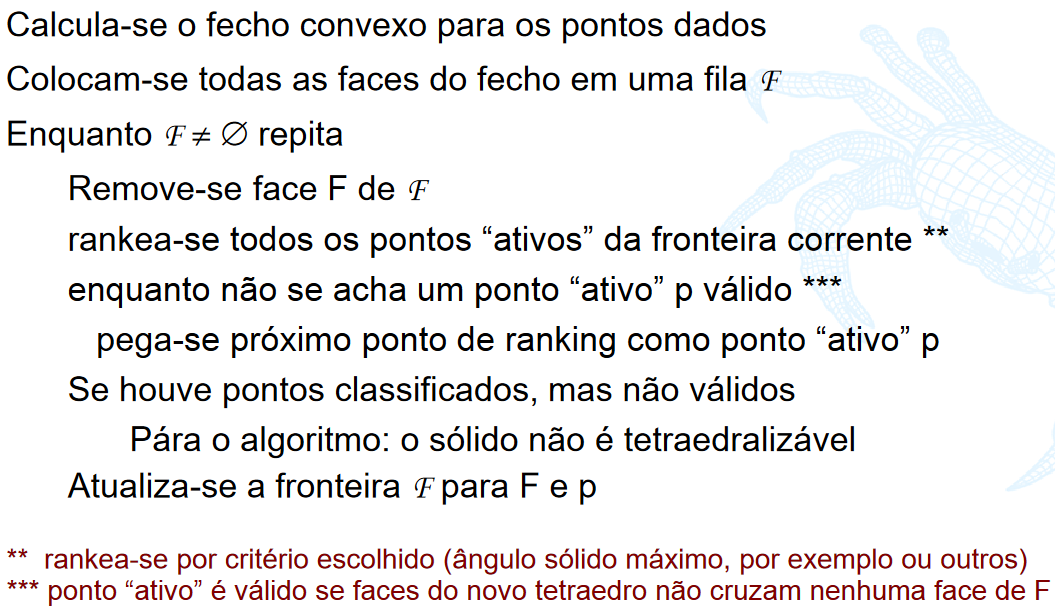

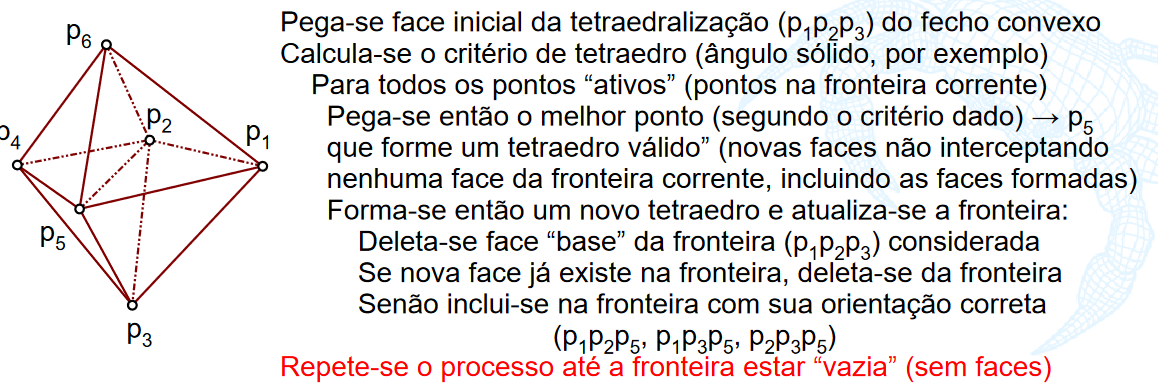

In [ ]:
def tetraedralização(fecho_convexo, face_inicial):
    F = fecho_convexo.copy()
    output = fecho_convexo.copy()
    while(len(F)!=0):
        face_atual = F.pop(0)
        pontos = face2pontos(face_atual)
        pontos_rankeados = rankear(pontos)
        valido = False
        #while(!valido):
        for ponto_rankeado in pontos_rankeados:
            face_testar = geraFace(ponto_rankeado)
            valido = colisaoFaces(face_testar, output)
            if(valido):
                output.append(face_testar.copy())
                # para p1p2p3
                # add p1p2p5
                # add p1p3p5
                # add p2p3p5
                F.append(face_testar.copy())
                break
        if(!valido):
            print('Não tetraedralizável')
            break

In [41]:
tri = Delaunay(cubo[0])
#len(cubo[0])

In [42]:
tri.simplices

array([[3, 1, 0, 4],
       [3, 2, 0, 4],
       [3, 6, 7, 4],
       [3, 5, 7, 4],
       [3, 5, 1, 4],
       [3, 6, 2, 4]], dtype=int32)

In [37]:
points2 = np.array([[0, 0], [0, 1.1], [1, 0], [1, 1]])
points2[:,0]

array([0., 0., 1., 1.])

In [38]:
points

array([[ 1.,  1., -1.],
       [ 1., -1., -1.],
       [ 1.,  1.,  1.],
       [ 1., -1.,  1.],
       [-1.,  1., -1.],
       [-1., -1., -1.],
       [-1.,  1.,  1.],
       [-1., -1.,  1.]])

In [33]:
np.array(points)[:,0]

array([ 1.,  1.,  1.,  1., -1., -1., -1., -1.])

## Descartar:

In [ ]:
all_faces = []
init_face = [v1[1], v2, v3]
aux_inits = [
    (v1[1], v2), (v2, v3), (v3, v1[1])
]

faces = [init_face]
faces_final = [init_face]
# aux_obj01
while(len(faces)!=0):
    face = faces.pop(0)
    aux_vtx = splitFace(face)
    for aresta in face:
        coss = np.inf
        ponto_found = None
        idx_ponto_found = None
        vtx_face = splitFace(face)
        ponto_op = pontoOposto(aresta, vtx_face)
        for idx_ponto, ponto in enumerate(reconstructed_obj[0]):
            print(aresta, ponto)
            normal_p = calc_normal(aresta, ponto)
            normal_  = calc_normal(aresta, ponto_op)

            prodEsc = produtoEsc(normal_p, normal_)

            nor1 = calc_nor(normal_p)
            nor2 = calc_nor(normal_)
            #print(nor1)
            aux_coss = prodEsc/(nor1*nor2)

            #print('aux_coss: ', aux_coss)
            #print('coss: ', coss)
            if coss > aux_coss:
                print('aqui')
                coss = aux_coss
                ponto_found = ponto
                idx_ponto_found = idx_ponto

        del aux_obj01[idx_ponto_found]
        found_face = [aresta, (aresta[0], ponto_found), (aresta[1], ponto_found)]
        faces.append(found_face)
        faces_final.append(found_face) # na verdade deveria ser cmo na linha comentad abaixo
    #faces_final.append(face) # e faces_final não inicia com nenhuma face dentro
all_faces.append(faces_final.copy())
        # etapa 4
        # etapa 5

In [ ]:
len(all_faces)

In [ ]:
# descartar
# for obj in reconstructed_obj:
#     aux_obj01 = obj.copy()
#     #print(len(reconstructed_obj), len(aux_obj01))
#     minus_idx, minus01 = primeiraFace(aux_obj01)
#     print('minus 01: ', minus_idx, minus01)
#     print('aux_obj01[minus_idx]', aux_obj01[minus_idx])
#     del aux_obj01[minus_idx]
#     print(len(aux_obj01))
    
#     minus_idx, minus02 = primeiraFace(aux_obj01)
#     del aux_obj01[minus_idx]
#     print(len(aux_obj01))
#     #minus_idx, len(aux_obj01), minus02
    
#     minus_idx, minus03 = primeiraFace(aux_obj01)
#     del aux_obj01[minus_idx]
#     print(len(aux_obj01))
#     init_face = [minus01, minus02, minus03]
#     print('init_face: ', init_face)
#     aux_objs.append(aux_obj01.copy())
#     init_faces.append(init_face.copy())

#### Células de testagens

In [ ]:
minus_idx, minus01

In [ ]:
print(aux_obj01[minus_idx])
del aux_obj01[minus_idx]
print(len(aux_obj01))

In [ ]:
minus_idx, minus02 = primeiraFace(aux_obj01)
del aux_obj01[minus_idx]
print(len(aux_obj01))
#minus_idx, len(aux_obj01), minus02

In [ ]:
minus_idx, minus03 = primeiraFace(aux_obj01)
del aux_obj01[minus_idx]
print(len(aux_obj01))
init_face = [minus01, minus02, minus03]
init_face

In [ ]:
init_face

In [ ]:
init_face = [(init_face[0], init_face[1]), (init_face[0], init_face[2]), (init_face[1], init_face[2])]

In [ ]:
init_face

# Algoritmo

In [ ]:
# 1 encontre a primeira face
# 2 repita:
# 3 para cada aresta da face:
# 4 calcule o ângulo entre cada ponto restante e essa aresta (aresta, ponto) com F
# 5 o menor você guarda como sendo da face aresta, ponto
# 6 repita até esgotar tudo

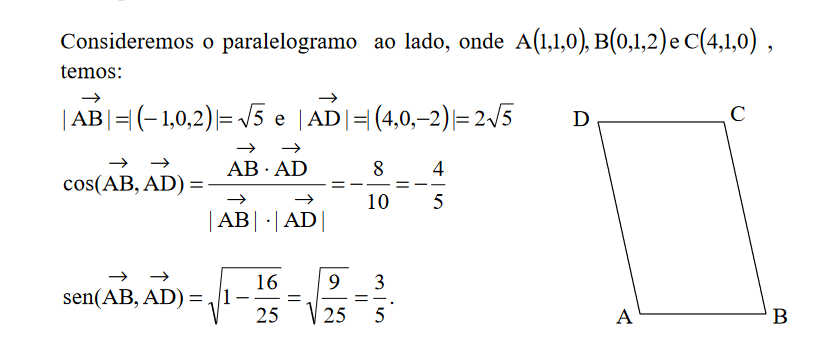

In [ ]:
splited_init_face = splitFace(init_face)
splited_init_face

In [ ]:
init_face[0]

In [ ]:
print('splited_init_face: ', splited_init_face, '\naresta: ', init_face[0],
      '\nvtx: ', splited_init_face[0], '\npontoOposto: ', pontoOposto(init_face[0], splited_init_face))

In [ ]:
init_faces[0]

In [ ]:
aux_inits = []
for init_face in init_faces:
    init_facer = [(init_face[0], init_face[1]), (init_face[0], init_face[2]), (init_face[1], init_face[2])]
    aux_inits.append(init_facer.copy())
aux_inits

In [ ]:
for init_face, aux_obj01 in zip(aux_inits, aux_objs):
    print(len(aux_obj01))

In [ ]:
all_faces = []
for init_face, aux_obj01 in zip(aux_inits, aux_objs):
    faces = [init_face]
    faces_final = [init_face]
    # aux_obj01
    while(len(faces)!=0):
        face = faces.pop(0)
        aux_vtx = splitFace(face)
        for aresta in face:
            coss = np.inf
            ponto_found = None
            idx_ponto_found = None
            vtx_face = splitFace(face)
            ponto_op = pontoOposto(aresta, vtx_face)
            for idx_ponto, ponto in enumerate(aux_obj01):
                normal_p = calc_normal(aresta, ponto)
                normal_  = calc_normal(aresta, ponto_op)

                prodEsc = produtoEsc(normal_p, normal_)

                nor1 = calc_nor(normal_p)
                nor2 = calc_nor(normal_)
                #print(nor1)
                aux_coss = prodEsc/(nor1*nor2)

                #print('aux_coss: ', aux_coss)
                #print('coss: ', coss)
                if coss > aux_coss:
                    print('aqui')
                    coss = aux_coss
                    ponto_found = ponto
                    idx_ponto_found = idx_ponto

            del aux_obj01[idx_ponto_found]
            found_face = [aresta, (aresta[0], ponto_found), (aresta[1], ponto_found)]
            faces.append(found_face)
            faces_final.append(found_face) # na verdade deveria ser cmo na linha comentad abaixo
        #faces_final.append(face) # e faces_final não inicia com nenhuma face dentro
    all_faces.append(faces_final.copy())
            # etapa 4
            # etapa 5
        

In [ ]:
faces_final[0]

In [ ]:
splited_init_face

In [ ]:
splitFace(faces_final[1])

In [ ]:
spliteds = faces_spliter(faces_final)

In [ ]:
z = np.array([0,1])

In [ ]:
z.ndim

In [ ]:
x1,y1,z1 = spliteds[0]

In [ ]:
z1

In [ ]:
# for face in spliteds:
#     #face = np.array(face)
#     x,y,z = face
#     fig = plt.figure(figsize =(14, 9))
#     ax = plt.axes(projection ='3d')

#     # Creating plot
#     #ax.plot_surface(x, y, z)
#     #ax.plot_surface(init_face, init_face, init_face)
#     ax.plot_trisurf(x,y,z)

#     # show plot
# plt.show()

#### Salvamento dos arquivos

In [ ]:
f.close()

In [ ]:
len(faces_final)

In [ ]:
faces_final[0]

In [ ]:
sp = splitFace(faces_final[0])
'vertex ' + str(sp[0][0]) + ' ' + str(sp[0][1]) + ' ' + str(sp[0][2])

In [ ]:
sp

In [ ]:
names = [
    'wing_2_Mat_0.stl',
    'rear_fin_Mat_0.stl',
    'rear_fin_2_Mat_0.stl',
    'tail_Mat_0.stl',
    'wing_1_Mat_0.stl',
    'fusilage_new_Mat_0.stl'
]

In [ ]:
for name in names:
    f = open(name, 'x')
    f.write('solid points\n')
    limit = len(faces_final)
    idx_ff = 0
    while limit!=0:
        sp = splitFace(faces_final[idx_ff])
        f.write('facet normal 0 0 0 \n')
        f.write('outer loop \n')
        f.write('vertex ' + str(sp[0][0]) + ' ' + str(sp[0][1]) + ' ' + str(sp[0][2]) + '\n')
        f.write('vertex ' + str(sp[1][0]) + ' ' + str(sp[1][1]) + ' ' + str(sp[1][2]) + '\n')
        f.write('vertex ' + str(sp[2][0]) + ' ' + str(sp[2][1]) + ' ' + str(sp[2][2]) + '\n')
        f.write('endloop\n')
        f.write('endfacet\n')
        idx_ff += 1
        limit -= 1
    f.write('endsolid points')
    f.close()

## Teste de escrita output

In [ ]:
len(airplane_sr2_ultra_wing01)

In [ ]:
f.close()

In [ ]:
sp

In [ ]:
f = open("testeasa.stl", 'x')
f.write('solid points\n')

idx_ff = 0
for i in range(len(airplane_sr2_ultra_wing01)):
    #sp = splitFace(reconstructed_obj[0][idx_ff])
    
    f.write('facet normal 0 0 0 \n')
    f.write('outer loop \n')
    f.write('vertex ' + str(sp[0][0]) + ' ' + str(sp[0][1]) + ' ' + str(sp[0][2]) + '\n')
    f.write('vertex ' + str(sp[1][0]) + ' ' + str(sp[1][1]) + ' ' + str(sp[1][2]) + '\n')
    f.write('vertex ' + str(sp[2][0]) + ' ' + str(sp[2][1]) + ' ' + str(sp[2][2]) + '\n')
    f.write('endloop\n')
    f.write('endfacet\n')
    idx_ff += 1
    limit -= 1
    
f.write('endsolid points')
f.close()

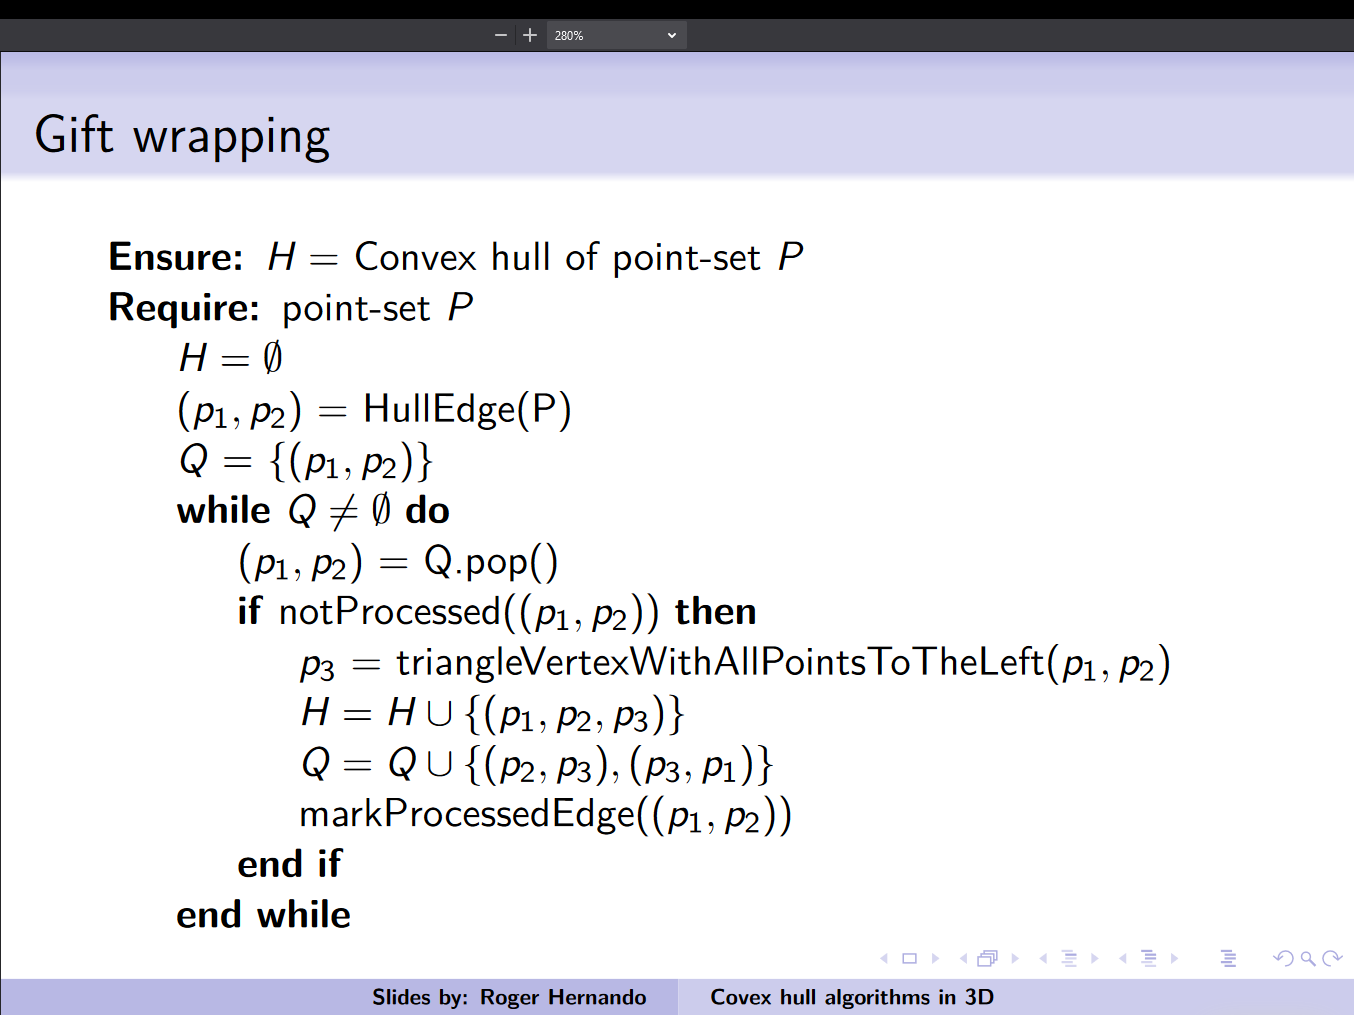

#### Células para testes

In [ ]:
lista = [v -45.812298 225.079575 297.913177
v -45.207600 229.974792 299.865601
v -54.857304 228.382431 301.110352
v -28.122997 225.565613 296.721436
v -28.428905 231.786194 298.824799
v -46.236217 219.332245 297.443604
v -58.728374 225.088348 300.071899
v -27.589016 218.350998 296.274323
v -6.026978 226.200592 296.076416
v 18.461050 227.125275 295.510651
v 18.493937 235.509583 297.504791
v -5.235962 217.693405 295.729645
v 19.031044 217.531281 295.339020
v -6.460651 233.587585 298.171875
v -4.267860 209.814484 297.019775
v -3.302933 204.312332 299.835022
v 20.854702 202.528152 299.812317
v -26.363674 211.632797 297.411102
v -25.154392 206.949097 300.044312
v 19.922674 208.681076 296.827148
v -44.239994 213.900314 298.426544
v -57.306278 216.054749 300.481628
v -52.411877 213.059738 301.804260
v -60.181278 220.505356 299.693756
v -42.267147 210.141571 300.771271
v 43.326393 228.480438 294.556610
v 44.231632 237.682831 296.421448
v 66.709534 229.832657 293.961823
v 68.295296 239.273575 295.683441
v 43.420094 218.036438 294.631805
v 66.454102 219.240738 294.219696
v 86.750961 230.748520 294.473877
v 103.236259 232.445023 296.398193
v 100.667145 238.483490 297.232788
v 86.655975 221.176086 294.714325
v 103.329727 223.907837 296.672241
v 88.227783 239.448105 296.052368
v 85.097855 212.420364 296.651886
v 84.080460 206.472610 299.902344
v 94.962067 210.810608 300.544403
v 66.409538 209.580048 296.202393
v 66.668587 203.008179 299.589600
v 99.823425 215.876801 298.418732
v 44.083141 208.468262 296.407745
v 44.885937 201.893402 299.645050
v 115.951035 236.139191 300.040283
v 109.195374 242.812973 299.844666
v 125.154526 240.203140 305.412537
v 117.857819 246.889511 304.937897
v 115.779388 227.501373 300.649963
v 124.342957 231.220398 306.296600
v 131.106018 243.008987 312.527435
v 133.263779 244.285812 320.553009
v 126.394196 250.289429 320.263947
v 129.358429 234.328598 313.261169
v 130.974167 235.912369 320.939850
v 133.263779 244.285812 320.553009
v 131.106018 243.008987 312.527435
v 123.976151 249.305038 312.076935
v 129.358429 234.328598 313.261169
v 131.106018 243.008987 312.527435
v 120.511673 224.900803 314.091827
v 106.344070 216.362488 314.833008
v 106.753098 218.398346 321.713654
v 116.971207 221.708832 307.515228
v 104.343460 213.195175 308.631226
v 121.484314 226.754684 321.351166
v 124.342957 231.220398 306.296600
v 110.261490 218.836884 302.165344
v 99.823425 215.876801 298.418732
v 94.962067 210.810608 300.544403
v 100.002518 211.119781 303.628479
v 110.261490 218.836884 302.165344
v 131.086029 243.762726 328.657349
v 123.955795 250.072540 328.501099
v 125.115570 241.641510 335.987701
v 117.818695 248.340317 335.818787
v 123.955795 250.072540 328.501099
v 129.338531 235.058044 328.728729
v 131.086029 243.762726 328.657349
v 124.303391 232.630707 335.940125
v 131.086029 243.762726 328.657349
v 115.895111 238.123901 341.691406
v 103.165100 234.836258 345.628235
v 100.601418 240.746490 344.228912
v 115.720764 229.495468 341.886444
v 103.252304 226.363647 346.147888
v 109.140610 244.778702 341.247437
v 110.199280 220.783218 341.164276
v 99.932419 213.056595 340.388092
v 94.877129 213.100021 343.476349
v 116.929230 223.084778 335.586761]

<div style="text-align: left"> 
    <h3>Referências:</h3>
    <ul><a href='https://www.cs.jhu.edu/~misha/Spring16/09.pdf'>link 1</a></ul>
    <ul><a href='https://dccg.upc.edu/people/vera/wp-content/uploads/2014/11/GA2014-ConvexHulls3D-Roger-Hernando.pdf'>link 2</a></ul>
    <ul><a href='https://cs.stackexchange.com/questions/100526/3d-gift-wrapping-algorithm-how-to-find-the-first-face-in-the-convex-hull'>link 3</a></ul>
</div>